In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import torchvision
from torchvision.io.image import ImageReadMode
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import TensorDataset, DataLoader
import tqdm

In [ ]:
class ResNetBlock(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        # self.norm1 = nn.BatchNorm2d(channels)
        # self.norm2 = nn.BatchNorm2d(channels)
        self.norm1 = nn.GroupNorm(8, channels)  # GroupNorm works well on small batchSize
        self.norm2 = nn.GroupNorm(8, channels)
        self.activation = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        residual = x
        x = self.activation(self.norm1(self.conv1(x)))
        x = self.norm2(self.conv2(x))
        return self.activation(x + residual)

class SelfAttention(nn.Module):
    def __init__(self, channels) -> None:
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.key = nn.Conv2d(channels, channels // 8, kernel_size=1)
        self.value = nn.Conv2d(channels, channels, kernel_size=1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        q = self.query(x).view(B, -1, H * W).permute(0, 2, 1)
        k = self.key(x).view(B, -1, H * W)
        v = self.value(x).view(B, -1, H * W)

        attention = self.softmax(torch.bmm(q, k) / (C ** 0.5))
        out = torch.bmm(v, attention.permute(0, 2, 1)).view(B, C, H, W)
        return out + x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, channels:int) -> None:
        super().__init__()
        self.mha = nn.MultiheadAttention(channels, 8, batch_first=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, C, H, W = x.shape
        x_flat:torch.Tensor = x.view(B, C, H * W).permute(0, 2, 1)
        x_attn, _ = self.mha(x_flat, x_flat, x_flat)
        x_attn = x_attn.permute(0, 2, 1).view(B, C, H, W)
        return x + x_attn

class Denoiser(nn.Module):
    def __init__(self, in_channels: int = 3, base_channels: int = 128) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
            ResNetBlock(base_channels),
            SelfAttention(base_channels),
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=2, padding=1),
            ResNetBlock(base_channels * 2),
            SelfAttention(base_channels * 2),
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, stride=2, padding=1),
            ResNetBlock(base_channels * 4),
            SelfAttention(base_channels * 4),
        )

        self.middle = nn.Sequential(
            ResNetBlock(base_channels * 4),
            ResNetBlock(base_channels * 4)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=4, stride=2, padding=1),
            ResNetBlock(base_channels * 2),
            SelfAttention(base_channels * 2),
            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1),
            ResNetBlock(base_channels),
            SelfAttention(base_channels),
            nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x
    
class BigDenoiser(nn.Module):
    def __init__(self, in_channels: int = 3, base_channels: int = 256) -> None:
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, base_channels, kernel_size=3, padding=1),
            ResNetBlock(base_channels),
            ResNetBlock(base_channels),
            MultiHeadSelfAttention(base_channels),
            nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, stride=2, padding=1),
            ResNetBlock(base_channels * 2),
            ResNetBlock(base_channels * 2),
            MultiHeadSelfAttention(base_channels * 2),
            nn.Conv2d(base_channels * 2, base_channels * 4, kernel_size=3, stride=2, padding=1),
            ResNetBlock(base_channels * 4),
            ResNetBlock(base_channels * 4),
            MultiHeadSelfAttention(base_channels * 4),
        )

        self.middle = nn.Sequential(
            ResNetBlock(base_channels * 4),
            ResNetBlock(base_channels * 4),
            ResNetBlock(base_channels * 4),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(base_channels * 4, base_channels * 2, kernel_size=4, stride=2, padding=1),
            ResNetBlock(base_channels * 2),
            ResNetBlock(base_channels * 2),
            MultiHeadSelfAttention(base_channels * 2),
            nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=4, stride=2, padding=1),
            ResNetBlock(base_channels),
            ResNetBlock(base_channels),
            MultiHeadSelfAttention(base_channels),
            nn.Conv2d(base_channels, in_channels, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.middle(x)
        x = self.decoder(x)
        return x


In [29]:
def load_dataset() -> list[torch.Tensor]:
    images_dir:str = os.path.join(os.getcwd(), "Dataset", "64x64")
    images_path:list[str] = os.listdir(images_dir)
    images:list[torch.Tensor] = list[torch.Tensor]()

    for image_local_path in images_path:
        image_absolute_path:str = os.path.join(images_dir, image_local_path)
        image:torch.Tensor = torchvision.io.read_image(image_absolute_path, ImageReadMode.RGB).type(torch.float32) / 255.0
        images.append(image)

    return images

dataset:list[torch.Tensor] = load_dataset()

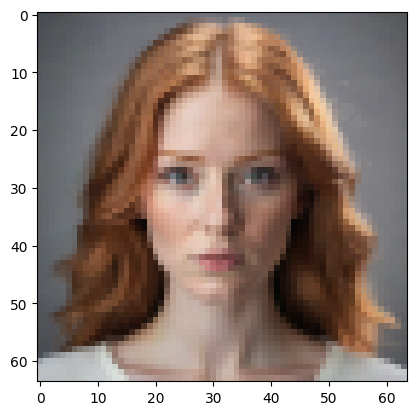

In [30]:
def plot_dataset_image(nb_image:int) -> None:
    for _ in range(0, nb_image):
        index:int = random.randint(0, len(dataset) - 1)
        image:torch.Tensor = dataset[index]
        image = image.permute(1, 2, 0)
        plt.imshow(image)
        plt.show()
        
plot_dataset_image(1)

In [31]:
def add_regular_noise(images:torch.Tensor, min_noise_delta:float, max_noise_delta:float, noise_variant_per_epoch:int, device:str = "cpu") -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = images.shape[0]
    new_images_lst:list[torch.Tensor] = list[torch.Tensor]()
    for i in range(0, batch_size):
        for _ in range(0, noise_variant_per_epoch):
            new_images_lst.append(images[i])
    new_images:torch.Tensor = torch.stack(new_images_lst).cpu()

    size:tuple[int] = (images.shape[0] * noise_variant_per_epoch, images.shape[1], images.shape[2], images.shape[3])
    noise:torch.Tensor = torch.rand(size)
    noise_deltas:torch.Tensor = (max_noise_delta - min_noise_delta) * torch.rand(batch_size * noise_variant_per_epoch) + min_noise_delta
    noise_levels:torch.Tensor = (torch.rand(batch_size * noise_variant_per_epoch) * (1.0 - noise_deltas)) + (noise_deltas * 0.5)

    min_noise_levels = noise_levels - (noise_deltas * 0.5)
    max_noise_levels = noise_levels + (noise_deltas * 0.5)

    min_noisy_images = (new_images * (1.0 - min_noise_levels.view(-1, 1, 1, 1))) + (noise * min_noise_levels.view(-1, 1, 1, 1))
    max_noisy_images = (new_images * (1.0 - max_noise_levels.view(-1, 1, 1, 1))) + (noise * max_noise_levels.view(-1, 1, 1, 1))

    return (min_noisy_images.to(device), max_noisy_images.to(device))

In [32]:
def add_gaussian_noise(images:torch.Tensor, min_noise_delta:float, max_noise_delta:float, noise_variant_per_epoch:int, device:str = "cpu") -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = images.shape[0]
    new_images_lst:list[torch.Tensor] = list[torch.Tensor]()
    for i in range(0, batch_size):
        for _ in range(0, noise_variant_per_epoch):
            new_images_lst.append(images[i])
    new_images:torch.Tensor = torch.stack(new_images_lst).cpu()

    size:tuple[int] = (images.shape[0] * noise_variant_per_epoch, images.shape[1], images.shape[2], images.shape[3])
    noise:torch.Tensor = torch.clamp(torch.normal(torch.ones(size) * 0.5, torch.ones(size) * 0.125), torch.zeros(size), torch.ones(size))
    noise_deltas:torch.Tensor = (max_noise_delta - min_noise_delta) * torch.rand(batch_size * noise_variant_per_epoch) + min_noise_delta
    noise_levels:torch.Tensor = (torch.rand(batch_size * noise_variant_per_epoch) * (1.0 - noise_deltas)) + (noise_deltas * 0.5)

    min_noise_levels = noise_levels - (noise_deltas * 0.5)
    max_noise_levels = noise_levels + (noise_deltas * 0.5)

    min_noisy_images = (new_images * (1.0 - min_noise_levels.view(-1, 1, 1, 1))) + (noise * min_noise_levels.view(-1, 1, 1, 1))
    max_noisy_images = (new_images * (1.0 - max_noise_levels.view(-1, 1, 1, 1))) + (noise * max_noise_levels.view(-1, 1, 1, 1))

    return (min_noisy_images.to(device), max_noisy_images.to(device))

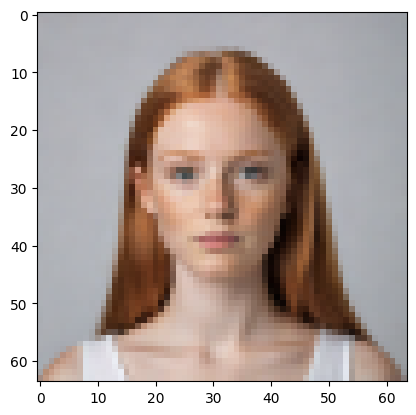

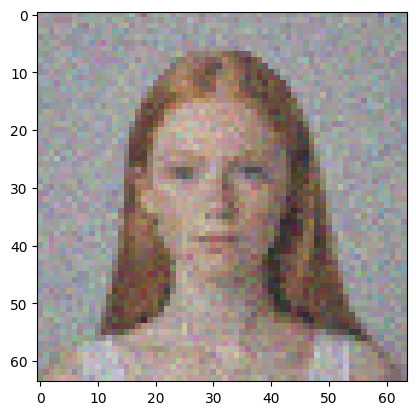

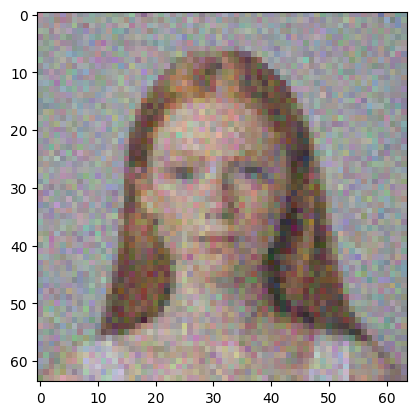

In [33]:
def plot_noisy_images(nb_image:int) -> None:
    images:torch.Tensor = torch.stack([dataset[random.randint(0, len(dataset))] for _ in range(0, nb_image)])
    nb_variants:int = 1
    noisy_images:tuple[torch.Tensor, torch.Tensor] = add_gaussian_noise(images, 0.025, 0.05, nb_variants, "cpu")

    for i in range(0, nb_image):
        plt.imshow(images[i].permute(1, 2, 0))
        plt.show()
        for j in range(0, nb_variants):
            plt.imshow(noisy_images[0][i * nb_variants + j].permute(1, 2, 0))
            plt.show()
            plt.imshow(noisy_images[1][i * nb_variants + j].permute(1, 2, 0))
            plt.show()

plot_noisy_images(1)

In [34]:
#training params
lr:float = 0.0001
batch_size:int = 1
epochs:int = 20
test_proportion:float = 0.1
min_noise_delta:float = 0.025
max_noise_delta:float = 0.025
noise_variant_per_epoch:int = 3
saving_model:bool = True
print_epoch_interval:int = 5
nb_sample_to_print:int = 1
device:str = "cuda" if torch.cuda.is_available() else "cpu"
print("Device : " + device)

Device : cuda


In [35]:
class TrainResult:
    denoiser:Denoiser
    train_losses:list[float]
    test_losses:list[float]

    def __init__(self, denoiser:Denoiser, train_losses:list[float], test_losses:list[float]) -> None:
        self.denoiser = denoiser
        self.train_losses = train_losses
        self.test_losses = test_losses

In [ ]:
def train_denoiser(model:Denoiser, train_dataset:list[torch.Tensor], test_dataset:list[torch.Tensor]) -> TrainResult:
    
    sample_to_print = min(nb_sample_to_print, batch_size)
    test_dataset_tensor:torch.Tensor = torch.stack(test_dataset).cpu()
    train_dataset_tensor:torch.Tensor = torch.stack(train_dataset).cpu()

    model = model.to(device)

    optimizer:torch.optim.Adam = torch.optim.Adam(model.parameters(), lr = lr)#,  weight_decay=1e-5) #weight_decay for L2 regularization
    criterion:nn.MSELoss = nn.MSELoss()
    train_losses:list[float] = list[float]()
    test_losses:list[float] = list[float]()

    print("Start training denoiser")
    with tqdm.tqdm(total=epochs, desc="Processing") as pbar:
        for epoch in range(0, epochs):
            print_sample = print_epoch_interval > 0 and ((epoch + 1) % print_epoch_interval == 0 or epoch + 1 == epochs)

            train_dataset_noise:tuple[torch.Tensor, torch.Tensor] = add_gaussian_noise(train_dataset_tensor, min_noise_delta, max_noise_delta, noise_variant_per_epoch, "cpu")
            tensor_dataset:TensorDataset = TensorDataset(train_dataset_noise[1], train_dataset_noise[0])
            train_loader:DataLoader = DataLoader(tensor_dataset, batch_size = batch_size, shuffle=True)

            for input_batch, expected_output_batch in train_loader:
                input_batch = input_batch.to(device)
                expected_output_batch = input_batch.to(device)
                optimizer.zero_grad()
                output_batch:torch.Tensor = model(input_batch)
                loss:torch.Tensor = criterion(output_batch, expected_output_batch)
                loss.backward()
                # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                if print_sample:
                    print_sample = False
                    for i in range(0, sample_to_print):
                        noisy_img:torch.Tensor = input_batch[i].detach().cpu()
                        denoise_image:torch.Tensor = output_batch[i].detach().cpu()
                        print("Noisy image :")
                        plt.imshow(noisy_img.permute(1, 2, 0))
                        plt.show()
                        print("Denoise image :")
                        plt.imshow(denoise_image.permute(1, 2, 0))
                        plt.show()

            train_losses.append(loss.item())
            
            test_dataset_noise:tuple[torch.Tensor, torch.Tensor] = add_gaussian_noise(test_dataset_tensor, min_noise_delta, max_noise_delta, 1, device)
            output_batch:torch.Tensor = model(test_dataset_noise[0])
            loss:torch.Tensor = criterion(output_batch, test_dataset_noise[1])
            test_losses.append(loss.item())

            if(epoch == 0 or  ((epoch + 1) % print_epoch_interval == 0) or epoch + 1 == epochs):
                print(f"Epoch {epoch+1}, Loss: {loss.item()}")
            
            pbar.update(1)

    if saving_model:
        path = "./Models/denoiser.model"
        if os.path.isfile(path):
            os.remove(path)

        torch.save(model.state_dict(), path)
        print(f"Denoiser Saved!")

    return TrainResult(model, train_losses, test_losses)

train_dataset:list[torch.Tensor] = None
test_dataset:list[torch.Tensor] = None
train_dataset, test_dataset = train_test_split(dataset, test_size = test_proportion, random_state=42, shuffle=True)

denoiser:Denoiser = Denoiser()
train_result:TrainResult = train_denoiser(denoiser, train_dataset, test_dataset)
denoiser = train_result.denoiser

Start training denoiser


Processing:   0%|          | 0/20 [00:00<?, ?it/s]

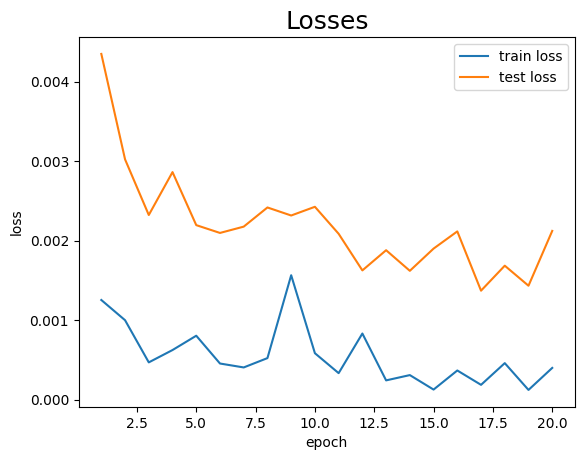

In [ ]:
def show_training_result(train_result:TrainResult) -> None:
    X:list[float] = [float(i) for i in range(1, epochs + 1)]
    plt.plot(X, train_result.train_losses, label='train loss')
    plt.plot(X, train_result.test_losses, label='test loss')
    plt.title("Losses", fontsize=18)
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

show_training_result(train_result)

In [ ]:
def load_denoiser() -> Denoiser:
    model:Denoiser = Denoiser()
    model_path:str = os.path.join(os.getcwd(), "Models", "denoiser.model")
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    return model

denoiser = load_denoiser()

param_size = 0
for param in denoiser.parameters():
    param_size += param.nelement() * param.element_size()

size_all_mb = (param_size + 0) / 1024**2
print("Model size: {:.3f}MB with {} parameters".format(size_all_mb, sum(p.numel() for p in denoiser.parameters())))

Model size: 82.996MB with 21756995 parameters


In [ ]:
class GenerationParam:
    denoise_step:int
    preview_interval:int
    device:str

    def __init__(self, denoise_step:int, preview_interval:int, device:str) -> None:
        self.denoise_step = denoise_step
        self.preview_interval = preview_interval
        self.device = device

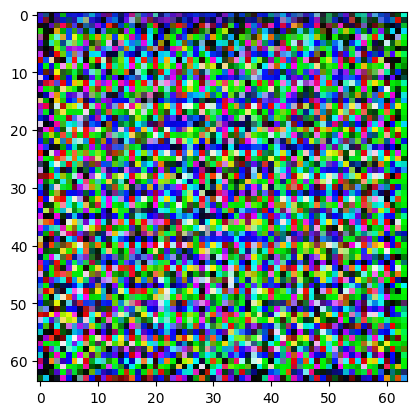

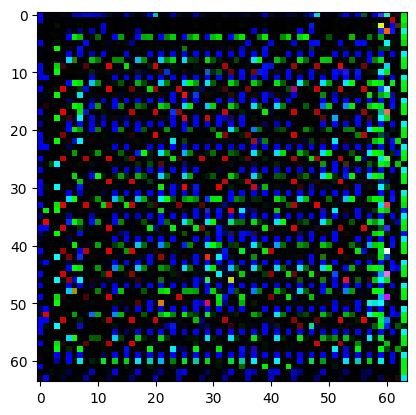

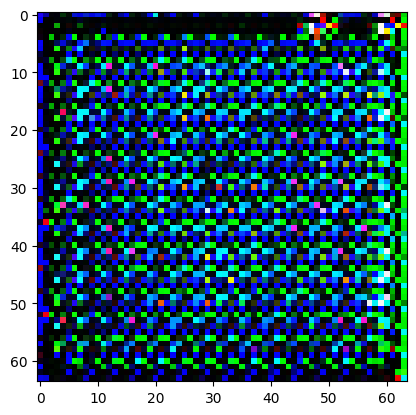

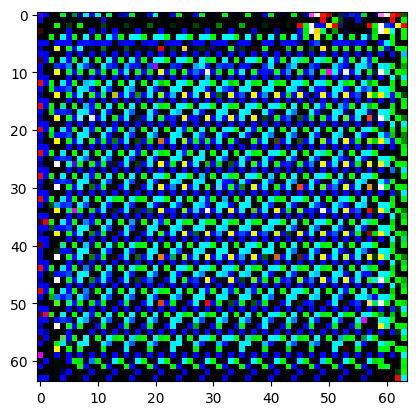

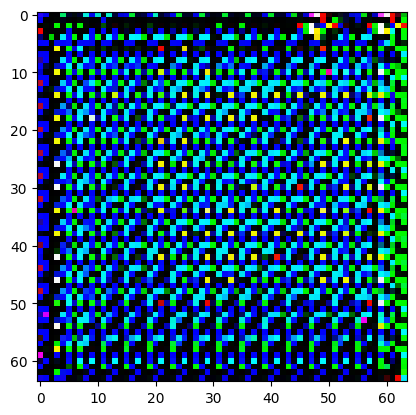

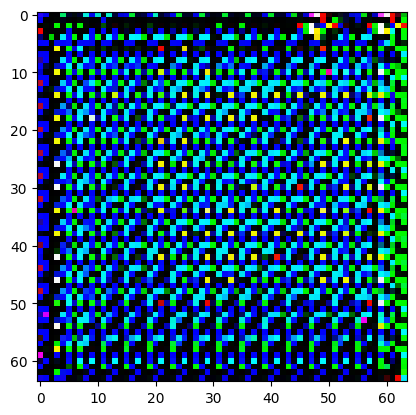

In [ ]:
def generate_face(denoiser:Denoiser, param:GenerationParam) -> torch.Tensor:
    denoiser = denoiser.to(device)
    # img:torch.Tensor = torch.rand(1, 3, 64, 64).to(device)
    size:tuple[int] = (1, 3, 64, 64)
    img:torch.Tensor = torch.clamp(torch.normal(torch.ones(size) * 0.5, torch.ones(size) * 0.125), torch.zeros(size), torch.ones(size))
    for i in range(param.denoise_step):
        img = denoiser(img)
        if param.preview_interval > 0 and ((i + 1) % param.preview_interval == 0 or i ==0):
            plot_img:torch.Tensor = img.cpu()[0]
            plot_img = plot_img.detach().permute(1, 2, 0)
            plt.imshow(plot_img)
            plt.show()

    return img[0].detach()

params = GenerationParam(50, 10, device)
image:torch.Tensor = generate_face(denoiser, params)
plt.imshow(image.cpu().permute(1, 2, 0))
plt.show()

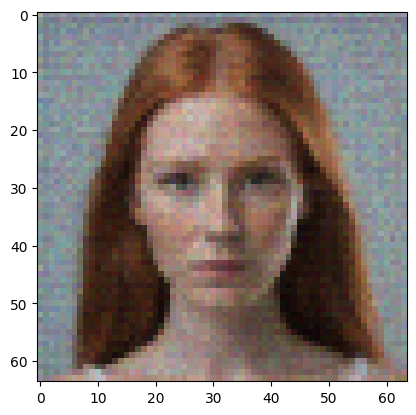

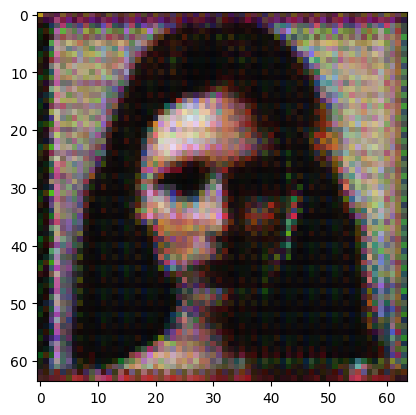

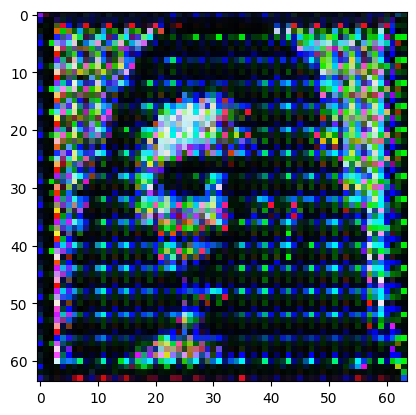

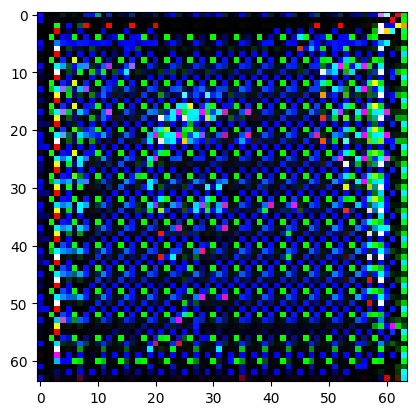

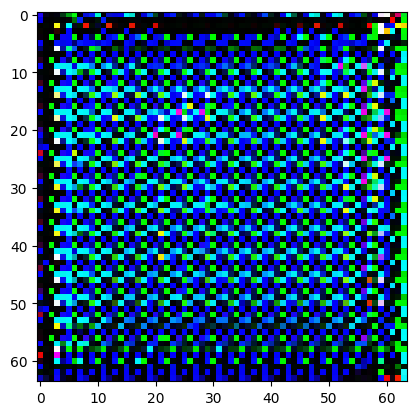

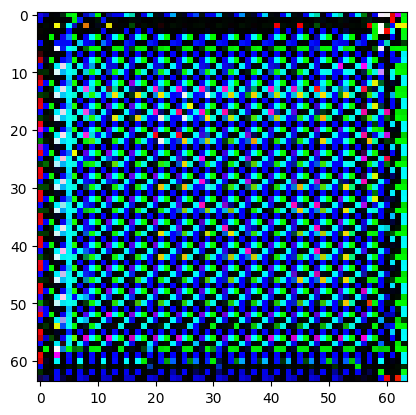

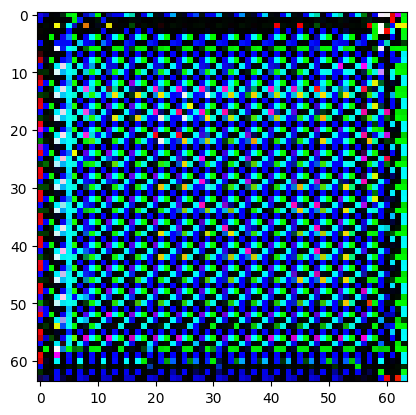

In [ ]:
def generate_face_bias(denoiser:Denoiser, param:GenerationParam, noice_level:float) -> torch.Tensor:
    denoiser = denoiser.to(device)
    start_image:torch.Tensor = dataset[random.randint(0, len(dataset) - 1)]
    # noise:torch.Tensor = torch.rand(start_image.shape)
    noise:torch.Tensor = torch.clamp(torch.normal(torch.ones(start_image.shape) * 0.5, torch.ones(start_image.shape) * 0.125), torch.zeros(start_image.shape), torch.ones(start_image.shape))

    start_image = (start_image * (1.0 - noice_level)) + (noise * noice_level)
    img:torch.Tensor = start_image.unsqueeze(0).to(device)
    for i in range(param.denoise_step):
        img = denoiser(img)
        if param.preview_interval > 0 and ((i + 1) % param.preview_interval == 0 or i == 0):
            plot_img:torch.Tensor = img.detach().cpu()[0].clone()
            plot_img = plot_img.permute(1, 2, 0)
            plt.imshow(plot_img)
            plt.show()

    return img[0].detach()

params = GenerationParam(50, 10, device)
image:torch.Tensor = generate_face_bias(denoiser, params, 0.1)
plt.imshow(image.cpu().permute(1, 2, 0))
plt.show()